Em um alto nível, LeNet (LeNet-5) consiste em duas partes: (i) um codificador convolucional que consiste em duas camadas convolucionais; e (ii) um bloco denso que consiste em três camadas totalmente conectadas

<img src="./img/lenet.svg">

As unidades básicas em cada bloco convolucional são uma camada convolucional, uma função de ativação sigmoid e uma subsequente operação média de pooling. Cada camada convolucional usa um kernel e uma função de ativação sigmoid. Essas camadas mapeiam entradas organizadas espacialmente a uma série de mapas de recursos bidimensionais, normalmente aumentando o número de canais. A primeira camada convolucional tem 6 canais de saída, enquanto o segundo tem 16. Cada operação de pooling (passo 2) reduz a dimensionalidade por um fator de por meio da redução da resolução espacial. O bloco convolucional emite uma saída com forma dada por (tamanho do lote, número de canal, altura, largura).

Para passar a saída do bloco convolucional para o bloco denso, devemos nivelar cada exemplo no minibatch. Em outras palavras, pegamos essa entrada quadridimensional e a transformamos na entrada bidimensional esperada por camadas totalmente conectadas: como um lembrete, a representação bidimensional que desejamos usa a primeira dimensão para indexar exemplos no minibatch e o segundo para dar a representação vetorial plana de cada exemplo. O bloco denso do LeNet tem três camadas totalmente conectadas, com 120, 84 e 10 saídas, respectivamente. Porque ainda estamos realizando a classificação, a camada de saída de 10 dimensões corresponde ao número de classes de saída possíveis.

In [4]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Oculta avisos (warnings) do TensorFlow
import tensorflow as tf


def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                               padding='same'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])


Tomamos uma pequena liberdade com o modelo original, removendo a ativação gaussiana na camada final. Fora isso, esta rede corresponde a arquitetura LeNet-5 original. **É possível alterar a rede para tentar implementar melhorias e/ou otimizações**

Ao passar a imagem por um canal único (preto e branco) através da rede e imprimir a forma de saída em cada camada, podemos inspecionar o modelo para ter certeza que suas operações se alinham com o que esperamos

<img src ='./img/lenet-vert.svg'>

In [5]:
X = tf.random.uniform((1, 28, 28, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)


Conv2D output shape: 	 (1, 28, 28, 6)
AveragePooling2D output shape: 	 (1, 14, 14, 6)
Conv2D output shape: 	 (1, 10, 10, 16)
AveragePooling2D output shape: 	 (1, 5, 5, 16)
Flatten output shape: 	 (1, 400)
Dense output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Dense output shape: 	 (1, 10)


Observe que a altura e largura da representação em cada camada ao longo do bloco convolucional é reduzido (em comparação com a camada anterior). A primeira camada convolucional usa 2 pixels de preenchimento para compensar a redução de altura e largura que de outra forma resultaria do uso de um kernel . Em contraste, a segunda camada convolucional dispensa o preenchimento, e, portanto, a altura e a largura são reduzidas em 4 pixels. Conforme subimos na pilha de camadas, o número de canais aumenta camada sobre camada de 1 na entrada a 6 após a primeira camada convolucional e 16 após a segunda camada convolucional. No entanto, cada camada de pooling divide a altura e a largura pela metade. Finalmente, cada camada totalmente conectada reduz a dimensionalidade, finalmente emitindo uma saída cuja dimensão corresponde ao número de classes.

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Carregar o conjunto de dados
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Dividir o conjunto de treinamento em treino e validação (20% para validação)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Agora temos:
# - x_train, y_train -> dados de treino
# - x_val, y_val -> dados de validação
# - x_test, y_test -> dados de teste


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 23s 1us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 4s 1us/step


### Treinamento

In [21]:
import time
import tensorflow as tf
import matplotlib.pyplot as plt

class TrainCallback(tf.keras.callbacks.Callback):
    """Callback para visualizar o progresso do treinamento."""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.start_time = None
        self.epoch_times = []
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name

        # Configuração do gráfico de perda e acurácia
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlabel("Epoch")
        self.ax.set_xlim(1, num_epochs)
        self.ax.set_ylabel("Metrics")
        self.ax.legend(["Train Loss", "Train Acc", "Test Acc"])
        self.metrics = {"train_loss": [], "train_acc": [], "test_acc": []}

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        self.epoch_times.append(end_time - self.start_time)

        test_acc = self.net.evaluate(self.test_iter, verbose=0, return_dict=True)['accuracy']
        self.metrics["train_loss"].append(logs["loss"])
        self.metrics["train_acc"].append(logs["accuracy"])
        self.metrics["test_acc"].append(test_acc)

        print(f'Epoch {epoch+1}/{self.num_epochs}: '
              f'Loss {logs["loss"]:.3f}, Train Acc {logs["accuracy"]:.3f}, '
              f'Test Acc {test_acc:.3f}')

        # Atualiza o gráfico
        self.ax.clear()
        self.ax.set_xlabel("Epoch")
        self.ax.set_xlim(1, self.num_epochs)
        self.ax.set_ylabel("Metrics")
        self.ax.plot(range(1, epoch + 2), self.metrics["train_loss"], label="Train Loss")
        self.ax.plot(range(1, epoch + 2), self.metrics["train_acc"], label="Train Acc")
        self.ax.plot(range(1, epoch + 2), self.metrics["test_acc"], label="Test Acc")
        self.ax.legend()
        plt.pause(0.01)  # Atualiza o gráfico dinamicamente

        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(self.train_iter).numpy()
            avg_time = sum(self.epoch_times) / len(self.epoch_times)
            print(f'{num_examples / avg_time:.1f} examples/sec on {self.device_name}')

def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
    """Treina um modelo com GPU."""
    strategy = tf.distribute.OneDeviceStrategy(device)  # Use a string diretamente

    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    callback = TrainCallback(net, train_iter, test_iter, num_epochs, device)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net


ValueError: Input 0 of layer "conv2d_8" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (32, 28, 28)

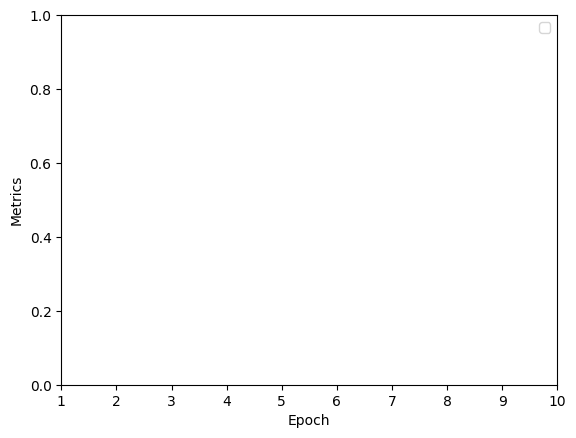

In [22]:
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

lr, num_epochs = 0.9, 10
train_ch6(net, x_train, x_test, num_epochs, lr, device)
